In [1]:
# you might need these, I'll update the docker image soon!
! pip install geopandas GPSphoto exifread piexif cameratransform folium

In [2]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import multiprocessing
import glob, shutil, os

import cv2
import numpy as np
import matplotlib.pyplot as plt


import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import exiftool
import datetime

import subprocess
import math

from utils_awedits3 import *
# from georeg import *


/usr/local/envs/micasense/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
#project_path = os.path.join('../../../', '10_01_20', '0002SET', '000_test')
#project_path = os.path.join('../../../', 'Lake_Erie', 'test')
#project_path = os.path.join('../../../', 'Lake_Erie', 'large_test')
project_path = os.path.join('.')
#project_path = os.path.join('../../DroneWQ/data/test/test_dir')
project_path

'.'

In [4]:
rrs_imgs, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_imgs')
#for some reason my altitudes were way high, think it might be due to the elevation at Oakland, MD (731 m)? 
#The Pix4D capture mission was 87 m so I just changed it to that. 
rrs_img_metadata['    GPSAltitude'] = 87 
rrs_img_metadata

,SourceFile,GPSDateStamp,GPSTimeStamp,GPSLatitude,GPSLatitudeRef,GPSLongitude,GPSLongitudeRef,GPSAltitude,FocalLength,ImageWidth,ImageHeight,GPSImgDirection,GPSPitch,GPSRoll,UTC-Time,id
filename,,,,,,,,,,,,,,,,
capture_1.tif,rrs_imgs/capture_1.tif,2022:09:09,14:31:40,39.413809,N,-79.370456,W,87,5.43432,1280,960,-103.581196,16.374511,-11.836916,2022-09-15 14:31:40,1
capture_2.tif,rrs_imgs/capture_2.tif,2022:09:09,14:31:42,39.413819,N,-79.370214,W,87,5.43432,1280,960,-104.439031,22.127797,-17.948192,2022-09-15 14:31:42,2
capture_3.tif,rrs_imgs/capture_3.tif,2022:09:09,14:31:43,39.413827,N,-79.370056,W,87,5.43432,1280,960,-94.381692,-6.805449,-19.689118,2022-09-15 14:31:43,3
capture_4.tif,rrs_imgs/capture_4.tif,2022:09:09,14:31:45,39.413823,N,-79.369929,W,87,5.43432,1280,960,-96.982867,13.240708,-8.054586,2022-09-15 14:31:45,4
capture_5.tif,rrs_imgs/capture_5.tif,2022:09:09,14:31:49,39.413850,N,-79.369918,W,87,5.43432,1280,960,-84.583511,18.062284,6.944021,2022-09-15 14:31:49,5
capture_6.tif,rrs_imgs/capture_6.tif,2022:09:09,14:31:52,39.414018,N,-79.369891,W,87,5.43432,1280,960,11.457355,-8.216104,17.387675,2022-09-15 14:31:52,6
capture_7.tif,rrs_imgs/capture_7.tif,2022:09:09,14:31:54,39.414145,N,-79.369860,W,87,5.43432,1280,960,77.679747,-8.370421,33.349038,2022-09-15 14:31:54,7
capture_8.tif,rrs_imgs/capture_8.tif,2022:09:09,14:31:58,39.414178,N,-79.369872,W,87,5.43432,1280,960,108.698283,2.466475,16.160407,2022-09-15 14:31:58,8
capture_9.tif,rrs_imgs/capture_9.tif,2022:09:09,14:32:01,39.414174,N,-79.370056,W,87,5.43432,1280,960,111.306860,13.037171,14.416145,2022-09-15 14:32:01,9


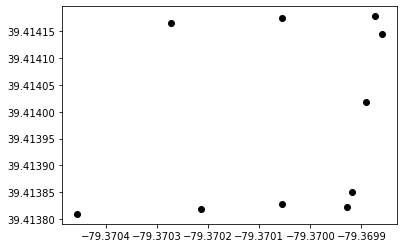

In [5]:
#These 10 images are during a curve of a transect that captures the shoreline of the lake. Trees are on the right, water on left
plt.scatter(rrs_img_metadata['    GPSLongitude'].values, rrs_img_metadata['    GPSLatitude'].values, color='black')
plt.ticklabel_format(useOffset=False)  
plt.show()

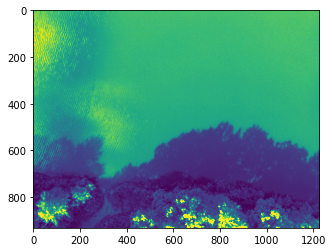

In [6]:
i = 9
plt.imshow(rrs_imgs[i,0,:,:], vmin=0.001, vmax=.012)
# plt.xlim(0,1226)
# plt.ylim(0,932)

In [7]:
f = rrs_img_metadata.iloc[i]['    FocalLength']
print(f)

image_size = [rrs_img_metadata.iloc[i]['    ImageWidth'], rrs_img_metadata.iloc[i]['ImageHeight']]
#print(image_size)

sensor_size = (4.8,3.6)

pitch = rrs_img_metadata.iloc[i]['GPSPitch']
roll = rrs_img_metadata.iloc[i]['GPSRoll']
yaw = rrs_img_metadata.iloc[i]['    GPSImgDirection']
print(yaw)
alt = rrs_img_metadata.iloc[i]['    GPSAltitude']
lat = rrs_img_metadata.iloc[i]['    GPSLatitude']
lon = rrs_img_metadata.iloc[i]['    GPSLongitude']

5.434319812499999
110.618292812219


In [8]:
image_size

[1280, 960]

# pgedits

The yaw is 110, so pointing basically east and a tiny bit south but the top of the image is looking out over the water, which should be a yaw of 110+180 = 290. So the images are backwards.

In [9]:
yaw, pitch, roll, alt

(110.618292812219, 11.388736622460982, 14.324571902078937, 87)

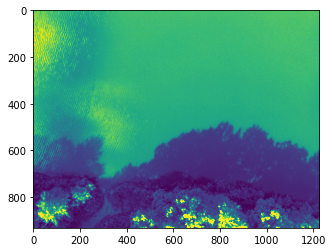

In [10]:
plt.imshow(rrs_imgs[i,0,:,:], vmin=0.001, vmax=.012)

In [11]:
import cameratransform as ct

cam = ct.Camera(ct.RectilinearProjection(focallength_mm=f,
                                         sensor=sensor_size,
#                                          image=image_size,
                                         # PGedits we can specify height and width instead of image size which I think is less confusing
                                         image_width_px=rrs_imgs[i,0,:,:].shape[1], # columns aka width
                                         image_height_px=rrs_imgs[i,0,:,:].shape[0], # rows aka height
                                        view_x_deg = 47.2, #This is the horizontal and vertical FOV from MicaSense website
                                        view_y_deg=35.4),
               ct.SpatialOrientation(elevation_m=alt,
                                     tilt_deg=pitch,
                                     roll_deg=roll,
                                    heading_deg=yaw,
                                    pos_x_m=0, pos_y_m=0))

# gps pts are lat lon
cam.setGPSpos(lat, lon, alt)

In [12]:

rrs_imgs[i,0,:,:].shape

(932, 1226)

In [13]:
rrs_imgs[i,0,:,:].T.shape

(1226, 932)

(800, 800)
the first image is meters the second is in pixels


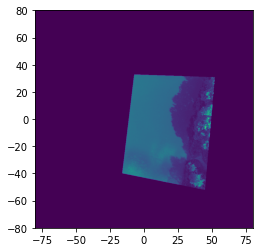

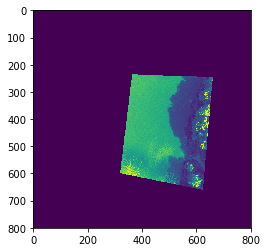

In [14]:
# pgedits this scaling factor is the size of the pixels in the final image so we can tune it depending on needs
# so when we set this to 0.2 and the image size to -80 to 80 meters (160m) we get an image size of 160/.2 = 800 pixels
scaling = .2

# pgedits normally we wouldn't need to flip this image but maybe it is an option in the code to flip if you have things
# integrated 180 from each other 
input_img = np.fliplr(np.flipud(rrs_imgs[i,0,:,:]))

# input_img = (rrs_imgs[i,0,:,:]

# this 120 value is approximate and based on altitude, FOV, and viewing geometry
# PGedits I moved these down to 80, they need to be larger if the pitch angle could be larger but I'm not certain
# how to automate this estimate, I think this is fine for now
top_im = cam.getTopViewOfImage(input_img, extent=[-80, 80,-80, 80], do_plot=True, scaling=scaling) #, skip_size_check=True, scaling=scaling)
print(top_im.shape)
print('the first image is meters the second is in pixels')
plt.xlim(-80,80)
plt.ylim(-80,80)

plt.show()


fig,ax = plt.subplots(figsize=(4,4))
ax.imshow(top_im, interpolation='nearest', vmin=0, vmax=0.0125)
plt.xlim(0,800)
plt.ylim(800,0)

plt.show()

# fig,ax = plt.subplots(figsize=(4,4))
# ax.pcolormesh(top_im, vmin=0, vmax=0.0065)

#plt.imshow and plt.pcolormesh look different

In [15]:
# space location / scaling factor - half the image

def spacetotopdown(top_im, cam, image_size, scaling):
    x1 = top_im.shape[0]/2 + cam.spaceFromImage([0,0])[0] / scaling
    y1 = top_im.shape[1]/2 - cam.spaceFromImage([0,0])[1] / scaling
    
    x2 = top_im.shape[0]/2 + cam.spaceFromImage([image_size[0]-1,0])[0] / scaling
    y2 = top_im.shape[1]/2 - cam.spaceFromImage([image_size[0]-1,0])[1] / scaling
    
    x3 = top_im.shape[0]/2 + cam.spaceFromImage([image_size[0]-1,image_size[1]-1])[0] / scaling
    y3 = top_im.shape[1]/2 - cam.spaceFromImage([image_size[0]-1,image_size[1]-1])[1] / scaling
    
    x4 = top_im.shape[0]/2 + cam.spaceFromImage([0,image_size[1]-1])[0] / scaling
    y4 = top_im.shape[1]/2 - cam.spaceFromImage([0,image_size[1]-1])[1] / scaling
    

    return(np.array([[x1,y1], [x2,y2], [x3,y3], [x4,y4]]))
    #return([x1,x2,x3,x4],[y1, y2, y3,y4])

[[659.15690837 247.07546279]
 [621.4032606  679.76865061]
 [309.82067557 614.18443489]
 [355.93745554 237.16007242]]


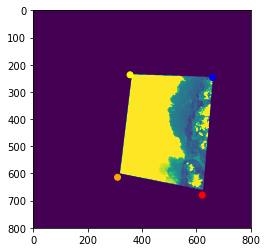

In [16]:
fig,ax = plt.subplots(figsize=(4,4))

# Now get the image coordinates of the corners of the original image but in the top down image
image_coords = spacetotopdown(top_im, cam, image_size, scaling=.2)
print(image_coords)

# show this image
ax.imshow(top_im, vmin=0, vmax=0.0065)
# ax.set_xlabel("x position in m")
# ax.set_ylabel("y position in m");
ax.scatter(image_coords[:,0],image_coords[:,1], c=('blue', 'red', 'orange', 'yellow'))

plt.xlim(0,800)
plt.ylim(800,0)

plt.show()


In [17]:
# these are the coordinates of the image corners   

coords = np.array([
    cam.gpsFromImage([0               , 0]), \
    cam.gpsFromImage([image_size[0]-1 , 0]), \
    cam.gpsFromImage([image_size[0]-1 , image_size[1]-1]), \
    cam.gpsFromImage([0               , image_size[1]-1])])

print(coords)

[[ 39.41444065 -79.36966996   0.        ]
 [ 39.4136624  -79.36975786   0.        ]
 [ 39.41378036 -79.37048324   0.        ]
 [ 39.41445849 -79.37037588   0.        ]]


In [18]:
image_coords[0,0], image_coords[0,1]

(659.1569083703976, 247.07546279159118)

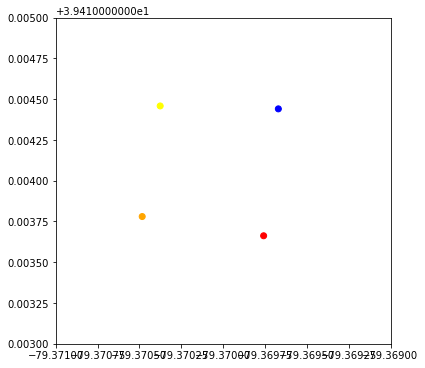

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(coords[:,1], coords[:,0], c=('blue', 'red', 'orange', 'yellow'))

plt.ylim(39.413,39.415)
plt.xlim(-79.371,-79.369)
plt.show()

In [20]:
image_coords

array([[659.15690837, 247.07546279],
       [621.4032606 , 679.76865061],
       [309.82067557, 614.18443489],
       [355.93745554, 237.16007242]])

In [21]:
image_coords[0,0]

659.1569083703976

In [22]:
coords

array([[ 39.41444065, -79.36966996,   0.        ],
       [ 39.4136624 , -79.36975786,   0.        ],
       [ 39.41378036, -79.37048324,   0.        ],
       [ 39.41445849, -79.37037588,   0.        ]])

# pgedits
This was incorrect and it took like ten times through to realize that we were putting x values into the row argument and y values into the column argument.

The image_coords go [(x,y),(x,y),(x,y),(x,y)] but the coords go [(lat,lon),(lat,lon),(lat,lon),(lat,lon)] which is basically (y,x) so they're backwards and need to be indexed as such so x into col, y into row, lon into x and lat into y.

In [23]:
gcp1 = rasterio.control.GroundControlPoint(row=image_coords[0,1], col=image_coords[0,0], x=coords[0,1], y=coords[0,0], z=coords[0,2], id=None, info=None)
gcp2 = rasterio.control.GroundControlPoint(row=image_coords[1,1], col=image_coords[1,0], x=coords[1,1], y=coords[1,0], z=coords[1,2], id=None, info=None)
gcp3 = rasterio.control.GroundControlPoint(row=image_coords[2,1], col=image_coords[2,0], x=coords[2,1], y=coords[2,0], z=coords[2,2], id=None, info=None)
gcp4 = rasterio.control.GroundControlPoint(row=image_coords[3,1], col=image_coords[3,0], x=coords[3,1], y=coords[3,0], z=coords[3,2], id=None, info=None)
[gcp1, gcp2, gcp3, gcp4]

[GroundControlPoint(row=247.07546279159118, col=659.1569083703976, x=-79.36966996011775, y=39.41444065136652, z=0.0, id='653f3fe6-3e17-4f1e-ba07-828b775f133c'),
 GroundControlPoint(row=679.7686506121386, col=621.4032605968531, x=-79.36975785965583, y=39.41366240174988, z=0.0, id='722cf328-5130-4791-9a45-088cbdf38c96'),
 GroundControlPoint(row=614.1844348854461, col=309.820675565577, x=-79.37048324334293, y=39.41378036369208, z=0.0, id='49ff30b2-750e-4752-bd51-85f02fd1569a'),
 GroundControlPoint(row=237.1600724236074, col=355.9374555403687, x=-79.37037588147217, y=39.41445848688575, z=0.0, id='0da24b6b-93ac-47c2-b888-87a7a4b18469')]

# pgedits

right now this is only writing band 1, we will need to do the cam.getTopViewOfImage for each band which should be a simple for loop and then we just call rasterio write one time with the arrayt of five images assuming they all have the same GCPs and everything.

In [24]:
input_filename = 'capture_10.tif'

with rasterio.Env():
    
    # open the original image to get some of the basic metadata
    with rasterio.open(os.path.join(project_path, 'rrs_imgs', input_filename), 'r') as src:
        profile = src.profile
        print('initial profile')
        print(profile)
               
        src_crs = "EPSG:4326"  # This is the crs of the GCPs
        dst_crs = "EPSG:4326"

        tsfm = rasterio.transform.from_gcps([gcp1,gcp2,gcp3,gcp4])
        print(tsfm)
        profile.update(
            dtype=rasterio.float32,
            transform = tsfm,
            crs=dst_crs,
            width=top_im.shape[1], # TODO unsure if this is correct order but they're the same value so okay for now
            height=top_im.shape[0]
        )
        
        print('updated profile')
        print(profile)
 
        with rasterio.open(os.path.join(project_path, 'georeferenced_imgs', input_filename), 'w', **profile) as dst:
            # we then need to transpose it because it gets flipped compared to expected output
            dst.write(top_im.astype(rasterio.float32), 1)
            # I believe this transpose is needed because we're going from (rows, columns) to (lat, lon) which are respectively
            # (y, x) (and )


initial profile
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1226, 'height': 932, 'count': 5, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}
| 0.00,-0.00,-79.37|
|-0.00,-0.00, 39.41|
| 0.00, 0.00, 1.00|
updated profile
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 800, 'height': 800, 'count': 5, 'crs': 'EPSG:4326', 'transform': Affine(2.3280751780827582e-06, -6.464968971053971e-12, -79.37120452710396,
       -3.979589709935484e-12, -1.7986186709857693e-06, 39.41488504867338), 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}


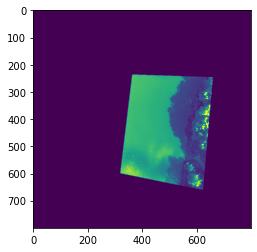

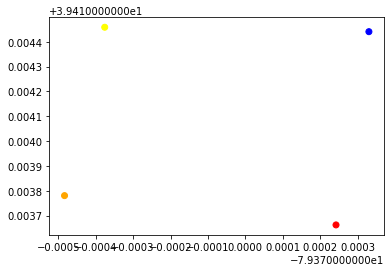

In [25]:
with rasterio.open(os.path.join(project_path, 'georeferenced_imgs', input_filename)) as source:    
    plt.imshow(source.read(1), vmin=0, vmax=0.0125)
    plt.show()
    
    plt.scatter(coords[:,1], coords[:,0], c=('blue', 'red', 'orange', 'yellow'))
    plt.show()
